# Managing Andrews Data

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()

import matplotlib
import matplotlib.pyplot as plt

keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


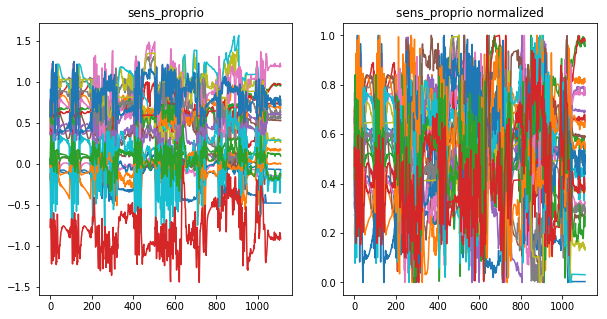

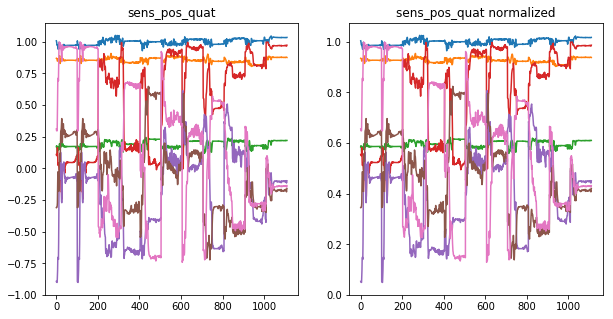

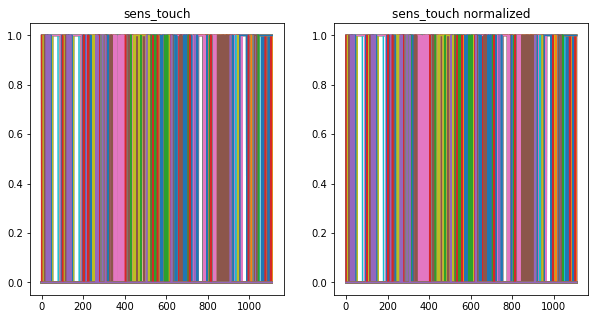

In [2]:
import urllib.request
import pickle
import os
import gzip

def download(url, location):    
    if not os.path.isfile(location):
        urllib.request.urlretrieve(url, location)

def norm_min_max(data, min = 0.0, max = 1.0, axis = None):
    data = data - np.min(data, axis = axis)
    data = data / np.max(data, axis = axis)
    data = (data * (min + max)) - min
    return data

filenames = ["multisensory_data_ep_162615.pgz", "multisensory_data_ep_162615.pgz", "multisensory_data_ep_162628.pgz", "multisensory_data_ep_162643.pgz", "multisensory_data_ep_162658.pgz", "multisensory_data_ep_162713.pgz", "multisensory_data_ep_162728.pgz", "multisensory_data_ep_162742.pgz", "multisensory_data_ep_162757.pgz", "multisensory_data_ep_162812.pgz", "multisensory_data_ep_162827.pgz"]
sens_proprio = None
sens_pos_quat = None
sens_touch = None
sens_voxel = None
for filename in filenames:
    url = "https://github.com/ndrwmlnk/baselines/blob/touchsensors_multisensory_data/HandManipulateBlockTouchSensors_multisensory_data/" + filename + "?raw=true"
    location = "/tmp/" + filename
    download(url, location)

    # Each file is a single episode (100 steps) and contains a dict:
    # senses = dict(
    # sens_proprio,  # 24 joint vaplues for - 24 degrees of freedom
    # sens_touch,  # 75 binary touch sensors: 0 - no touch, 1 - touch detected
    # sens_pos_quat,  # 7 value vectors: first 3 - XYZ of the cube, last 4 - quat values
    # sens_voxel  # 16x16x16 voxel space, cube shape is alwas in the center, cube size 8x8x8, check these links [1, 2] for visualization
    # )

    # Read '*.pgz' files:
    file = location
    with gzip.open(file, 'r') as f:
       data = pickle.load(f)
    #for k in data.keys():
    #   print(k, type(data[k]))
    
    if sens_proprio is None:
        sens_proprio = np.array(data["sens_proprio"])
    else:
        sens_proprio = np.append(sens_proprio, np.array(data["sens_proprio"]), axis=0)
    if sens_pos_quat is None:
        sens_pos_quat = np.array(data["sens_pos_quat"])
    else:
         sens_pos_quat = np.append(sens_pos_quat, np.array(data["sens_pos_quat"]), axis=0)
    if sens_touch is None:
        sens_touch = np.array(data["sens_touch"])
    else:
         sens_touch = np.append(sens_touch, np.array(data["sens_touch"]), axis=0)
    if sens_voxel is None:
        sens_voxel = np.array(data["sens_voxel"])
    else:
        sens_voxel = np.append(sens_voxel, np.array(data["sens_voxel"]), axis=0)


# sens_proprio
#sens_proprio = np.array(data["sens_proprio"])
f, axs = plt.subplots(1, 2, figsize=[10,5])
sens_proprio_norm = norm_min_max(sens_proprio, axis = 0)
axs[0].plot(sens_proprio)
axs[0].set_title("sens_proprio")
axs[1].plot(sens_proprio_norm)
axs[1].set_title("sens_proprio normalized")
plt.show()

# sens_pos_quat(float0..1 1x7)
#sens_pos_quat = np.array(data["sens_pos_quat"])
f, axs = plt.subplots(1, 2, figsize=[10,5])
sens_pos_quat_norm = sens_pos_quat * 0.5 + 0.5
axs[0].plot(sens_pos_quat)
axs[0].set_title("sens_pos_quat")
axs[1].plot(sens_pos_quat_norm)
axs[1].set_title("sens_pos_quat normalized")
plt.show()

# sens_voxel (float0..1 1x16x16x16 or 1x4096 if flatten)
#sens_voxel = np.array(data["sens_voxel"])
sens_voxel_norm = sens_voxel # already normalizes?
sens_voxel_flat_norm = sens_voxel_norm.reshape((len(sens_voxel_norm), np.prod(sens_voxel_norm.shape[1:])))
#print(sens_voxel_norm[0,0,0,:])
sens_voxel_norm_flatten = sens_voxel_norm.reshape((sens_voxel_norm.shape[0], -1))

# sens_touch (binary 1x75)
#sens_touch = np.array(data["sens_touch"])
f, axs = plt.subplots(1, 2, figsize=[10,5])
sens_touch_norm = sens_touch # already normalizes?
axs[0].plot(sens_touch)
axs[0].set_title("sens_touch")
axs[1].plot(sens_touch_norm)
axs[1].set_title("sens_touch normalized")
plt.show()

In [14]:
data = sens_touch_norm
batch_size = 16
original_dim = data.shape[1]
intermediate_dim = 128
epochs = 150
z_dim = 2
beta_norm = 0.01

encoder_touch = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

decoder_touch = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='sigmoid')           # Output layer
]]

vae_obj = MmVae(z_dim, encoder_touch, decoder_touch, [original_dim], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
# Store the losses, encodings, and decodings to tensorboard
losses_cb = vae_tools.callbacks.Losses(data = data)
# Train
vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
# Show the losses
vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
# Plot the embedding
encoder_input = [encoder_touch[0][0]]
encoder_mean_model = vae_obj.get_encoder_mean(encoder_input)
encoder_logvar_model = vae_obj.get_encoder_logvar(encoder_input)
mean_encoded = encoder_mean_model.predict(data, batch_size=batch_size)
var_encoded = np.sum(np.exp(encoder_logvar_model.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
plt.axis("equal")
plt.colorbar()
plt.show()

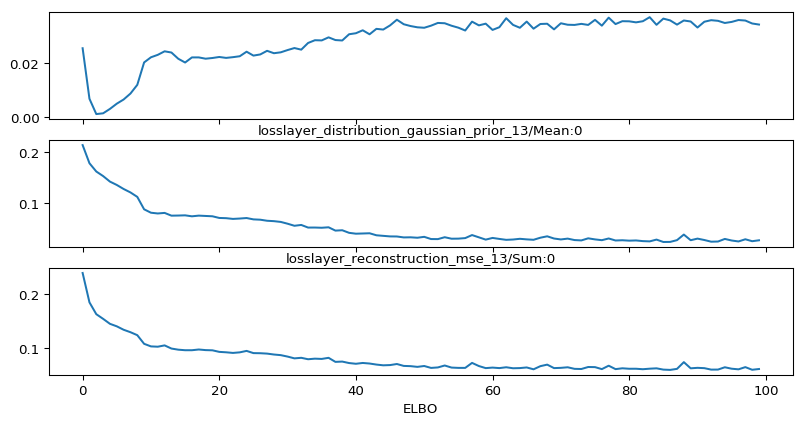

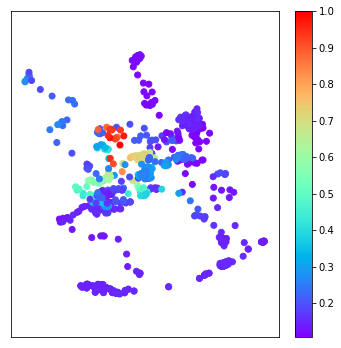

In [16]:
data = sens_pos_quat_norm
batch_size = 16
original_dim = data.shape[1]
intermediate_dim = 32
epochs = 100
z_dim = 2
beta_norm = 0.01

encoder_pos_quat = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

decoder_pos_quat = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='sigmoid')           # Output layer
]]

vae_obj = MmVae(z_dim, encoder_pos_quat, decoder_pos_quat, [original_dim], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
# Store the losses, encodings, and decodings to tensorboard
losses_cb = vae_tools.callbacks.Losses(data = data)
# Train
vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
# Show the losses
vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
# Plot the embedding
encoder_input = [encoder_pos_quat[0][0]]
encoder_mean_model = vae_obj.get_encoder_mean(encoder_input)
encoder_logvar_model = vae_obj.get_encoder_logvar(encoder_input)
mean_encoded = encoder_mean_model.predict(data, batch_size=batch_size)
var_encoded = np.sum(np.exp(encoder_logvar_model.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
plt.axis("equal")
plt.colorbar()
plt.show()

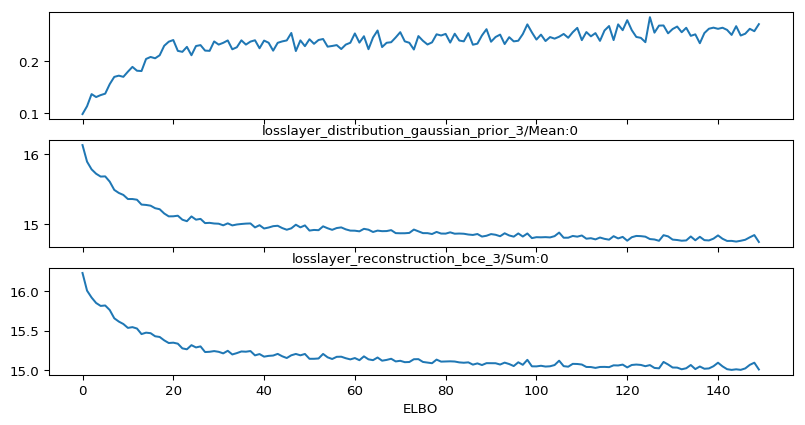

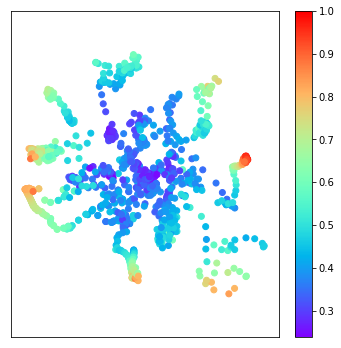

In [5]:
data = sens_proprio_norm
batch_size = 16
original_dim = data.shape[1]
intermediate_dim = 128
epochs = 150
z_dim = 2
beta_norm = 0.01

encoder_proprio = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

decoder_proprio = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='sigmoid')           # Output layer
]]

vae_obj = MmVae(z_dim, encoder_proprio, decoder_proprio, [original_dim], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
# Store the losses, encodings, and decodings to tensorboard
losses_cb = vae_tools.callbacks.Losses(data = data)
# Train
vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
# Show the losses
vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
# Plot the embedding
encoder_input = [encoder_proprio[0][0]]
encoder_mean_model = vae_obj.get_encoder_mean(encoder_input)
encoder_logvar_model = vae_obj.get_encoder_logvar(encoder_input)
mean_encoded = encoder_mean_model.predict(data, batch_size=batch_size)
var_encoded = np.sum(np.exp(encoder_logvar_model.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
plt.axis("equal")
plt.colorbar()
plt.show()

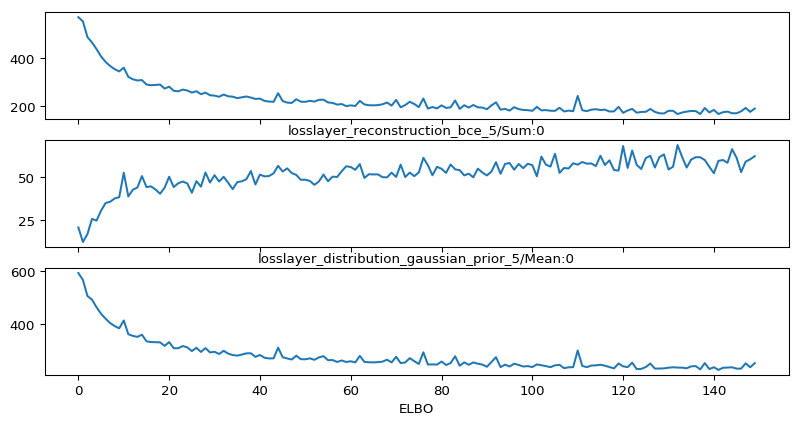

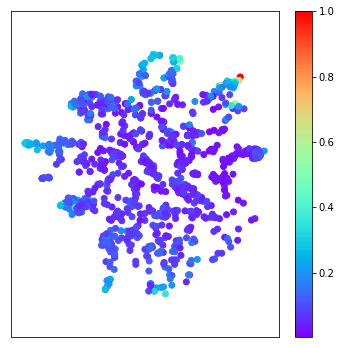

In [7]:
data = sens_voxel_flat_norm
batch_size = 16
original_dim = data.shape[1]
intermediate_dim = 256
epochs = 150
z_dim = 2
beta_norm = 0.01

encoder_voxel = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

decoder_voxel = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='sigmoid')           # Output layer
]]

vae_obj = MmVae(z_dim, encoder_voxel, decoder_voxel, [original_dim], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
# Store the losses, encodings, and decodings to tensorboard
losses_cb = vae_tools.callbacks.Losses(data = data)
# Train
vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
# Show the losses
vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
plt.show()
# Plot the embedding
encoder_input = [encoder_voxel[0][0]]
encoder_mean_model = vae_obj.get_encoder_mean(encoder_input)
encoder_logvar_model = vae_obj.get_encoder_logvar(encoder_input)
mean_encoded = encoder_mean_model.predict(data, batch_size=batch_size)
var_encoded = np.sum(np.exp(encoder_logvar_model.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
plt.axis("equal")
plt.colorbar()
plt.show()